In [108]:
import datacube
import datetime
import fiona
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio.mask
import rasterio.features
from shapely import geometry
import seaborn as sns
import sys
import xarray as xr

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from datacube.storage import masking
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser, write_geotiff

sys.path.append('/g/data/u46/users/ck9738/10_Scripts')
import TasseledCapTools

dc = datacube.Datacube(app='tcw')

%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
def three_band_image_flat(ds, bands, time = 0, figsize = [10,10], projection = 'projected'):
    '''
    threeBandImage takes three spectral bands from a dataframe with no time dimention, and plots them on the RGB 
    bands of an image. 
    
    Last modified: March 2018
    Author: Mike Barnes
    Modified by: Claire Krause
    Inputs: 
    ds -   Dataset containing the bands to be plotted
    bands - list of three bands to be plotted
    
    Optional:
    time - Index value of the time dimension of ds to be plotted
    figsize - dimensions for the output figure
    projection - options are 'projected' or 'geographic'. To determine if the image is 
    in degrees or northings
    '''
    y, x = ds[bands[0]].shape
    rawimg = np.zeros((y,x,3), dtype = np.float32)
    for i, colour in enumerate(bands):
        rawimg[:,:,i] = ds[colour].values
    rawimg[rawimg == -999] = np.nan
    img_toshow = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))
    fig = plt.figure(figsize = figsize)
    plt.imshow(img_toshow)
    ax = plt.gca()
    ax.set_title('title string', fontweight = 'bold', fontsize = 16)
    ax.set_xticklabels(ds.x.values)
    ax.set_yticklabels(ds.y.values)
    if projection == 'geographic':
        ax.set_xlabel('Longitude', fontweight = 'bold')
        ax.set_ylabel('Latitude', fontweight = 'bold')
    else:
        ax.set_xlabel('Eastings', fontweight = 'bold')
        ax.set_ylabel('Northings', fontweight = 'bold')

In [110]:

#define quiery

Year = '2018'

query = {
# jerrabombera wetland
'y': (-35.294, -35.325),
'x': (149.143, 149.173),
 
#gunbower
#'y': (-35.743, -35.909),
#'x': (144.235, 144.387),
    
    
'time': (Year + '-08-01', Year + '-09-28'),
'crs': 'EPSG:4326',
'output_crs': 'EPSG: 3577',
'resolution': (-25, 25)
}
    

In [111]:
data_lst8 = dc.load(product='ls8_nbart_albers', group_by='solar_day', **query)

In [112]:
data_lst8.isel(time=1)

<xarray.Dataset>
Dimensions:          (x: 618, y: 788)
Coordinates:
    time             datetime64[ns] 2018-08-12T00:08:38
  * y                (y) float64 -3.958e+06 -3.958e+06 ... -3.977e+06 -3.977e+06
  * x                (x) float64 1.102e+06 1.102e+06 ... 1.118e+06 1.118e+06
Data variables:
    coastal_aerosol  (y, x) int16 366 392 347 344 344 ... 286 275 290 295 287
    blue             (y, x) int16 332 377 334 326 329 ... 246 247 257 266 254
    green            (y, x) int16 483 529 462 451 451 ... 391 384 380 387 373
    red              (y, x) int16 569 635 537 517 540 ... 433 429 426 432 421
    nir              (y, x) int16 1887 1898 1860 1860 ... 1738 1713 1726 1706
    swir1            (y, x) int16 1739 1980 1674 1627 ... 1322 1313 1332 1303
    swir2            (y, x) int16 1147 1404 1119 1046 1104 ... 799 766 784 783
Attributes:
    crs:      EPSG: 3577

In [113]:
wofs_Data= dc.load(product = 'wofs_albers', **query)


In [114]:
wofs_Data.isel(time=1)

<xarray.Dataset>
Dimensions:  (x: 618, y: 788)
Coordinates:
    time     datetime64[ns] 2018-08-12T00:08:38
  * y        (y) float64 -3.958e+06 -3.958e+06 ... -3.977e+06 -3.977e+06
  * x        (x) float64 1.102e+06 1.102e+06 1.102e+06 ... 1.118e+06 1.118e+06
Data variables:
    water    (y, x) int16 8 8 8 8 8 8 8 8 0 0 0 0 8 ... 8 8 8 8 8 0 0 0 0 0 0 0
Attributes:
    crs:      EPSG: 3577

In [115]:
NDVI_data = (data_lst8['nir']-data_lst8['swir1'])/(data_lst8['nir']+data_lst8['swir1'])
NDVI_data

<xarray.DataArray (time: 7, y: 788, x: 618)>
array([[[ 0.539064,  0.537899, ...,  0.565973,  0.565992],
        [ 0.538246,  0.538922, ...,  0.565858,  0.566349],
        ...,
        [ 0.499004,  0.498896, ..., -0.      , -0.      ],
        [ 0.497174,  0.497883, ..., -0.      , -0.      ]],

       [[ 0.040816, -0.021145, ...,  0.103177,  0.062882],
        [ 0.070982,  0.035889, ...,  0.130725,  0.115137],
        ...,
        [-0.07056 , -0.084875, ...,  0.131814,  0.127927],
        [-0.075479, -0.106573, ...,  0.128842,  0.133932]],

       ...,

       [[-0.065661, -0.11361 , ..., -0.015718, -0.062565],
        [-0.039319, -0.048063, ..., -0.004618, -0.053659],
        ...,
        [ 0.018975, -0.018204, ...,  0.021169,  0.009579],
        [-0.003168, -0.046154, ...,  0.021595,  0.019142]],

       [[-0.058061, -0.077549, ...,  0.028526, -0.038784],
        [ 0.002908,  0.015733, ...,  0.04618 ,  0.023355],
        ...,
        [ 0.020739, -0.012242, ..., -0.      , -0.      ],

In [116]:
NDVI_Once = NDVI_data.isel(time=1)

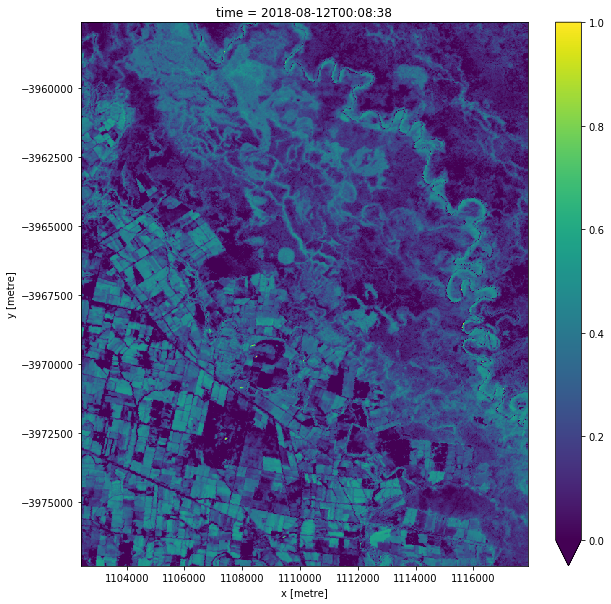

In [145]:
NDVI_data.isel(time=1).plot(cmap='viridis',figsize=(10,10), vmin=0, vmax=1)

In [118]:
data_lst8_once = data_lst8.isel(time=1)

#Prepare geomedian imagery for plotting

rgb = data_lst8_once.to_array(dim='color').sel(color=[
    'red','green', 'blue']).transpose('y', 'x', 'color')
fake_saturation = 2000.0  #you may need to adjust this to get a clear image. higher numbers will make it darker, 
                                                                            #lower will make it ligher
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

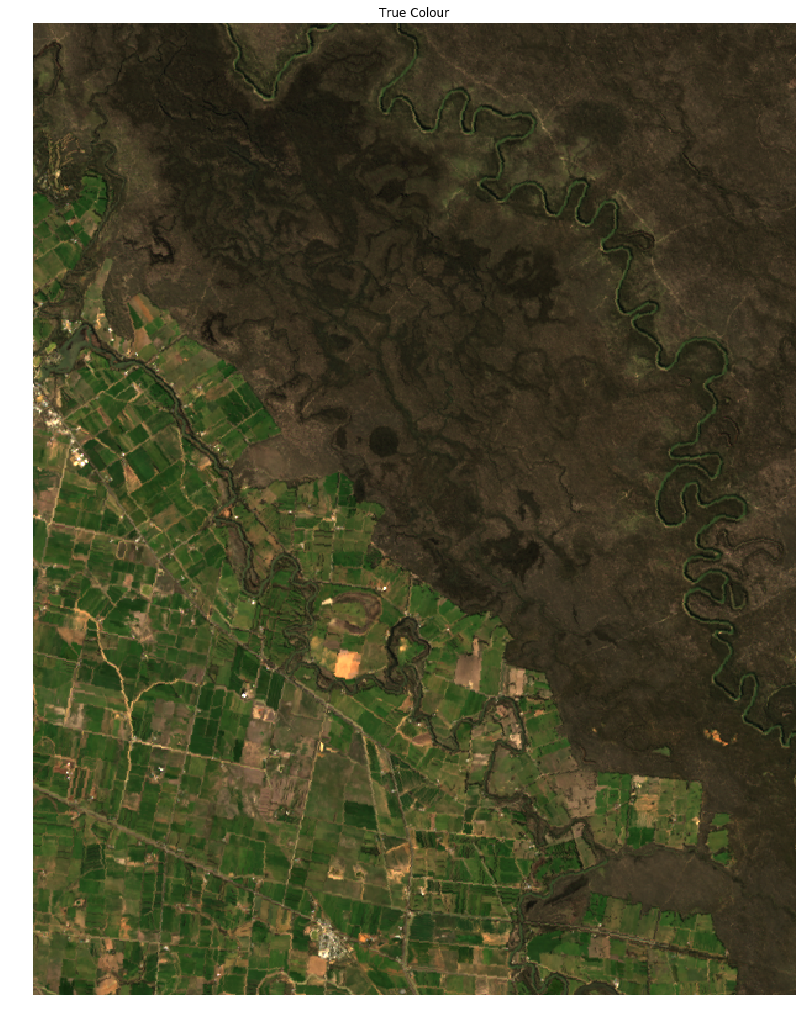

In [119]:
fig = plt.figure(figsize =(15,15)) #edit size of plot 
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #set border dimensions
fig.patch.set_facecolor('white') #make border white 
fig.patch.set_alpha(0.99)#ensure border white
plt.axis('off')#remove axis 
plt.title('True Colour') #add title
plt.imshow(scaled, interpolation = 'nearest') #create image

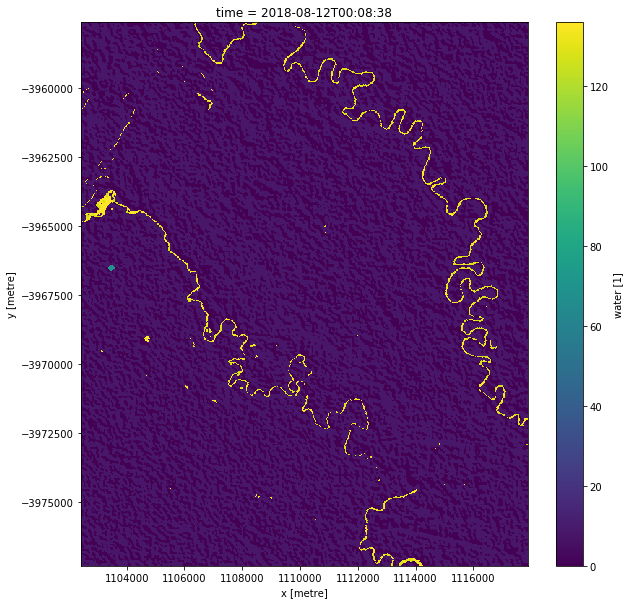

In [120]:
wofs_Data.isel(time=1).water.plot(figsize=(10,10))

In [121]:
wofs_wet = wofs_Data.isel(time=1).water.where(wofs_Data.isel(time=1).water >=128, 1)

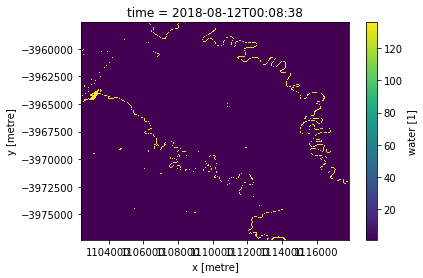

In [122]:
wofs_wet.plot()

In [123]:
TCI = TasseledCapTools.thresholded_tasseled_cap(data_lst8,wetness_threshold=-1200, drop=True
                                                , drop_tc_bands=False)

In [138]:
TCI

<xarray.Dataset>
Dimensions:                 (time: 7, x: 618, y: 788)
Coordinates:
  * time                    (time) datetime64[ns] 2018-08-03T00:14:44 ... 2018-09-20T00:15:03
  * y                       (y) float64 -3.958e+06 -3.958e+06 ... -3.977e+06
  * x                       (x) float64 1.102e+06 1.102e+06 ... 1.118e+06
Data variables:
    greenness               (time, y, x) float64 -1.434e+03 -1.453e+03 ... 286.1
    greenness_thresholded   (time, y, x) float64 nan nan nan nan ... nan nan nan
    brightness              (time, y, x) float64 1.367e+04 ... -2.287e+03
    brightness_thresholded  (time, y, x) float64 1.367e+04 1.383e+04 ... nan nan
    wetness                 (time, y, x) float64 2.038e+03 2.042e+03 ... 587.7
    wetness_thresholded     (time, y, x) float64 2.038e+03 2.042e+03 ... 587.7
Attributes:
    crs:      EPSG: 3577

In [124]:
tcw = TCI['wetness']


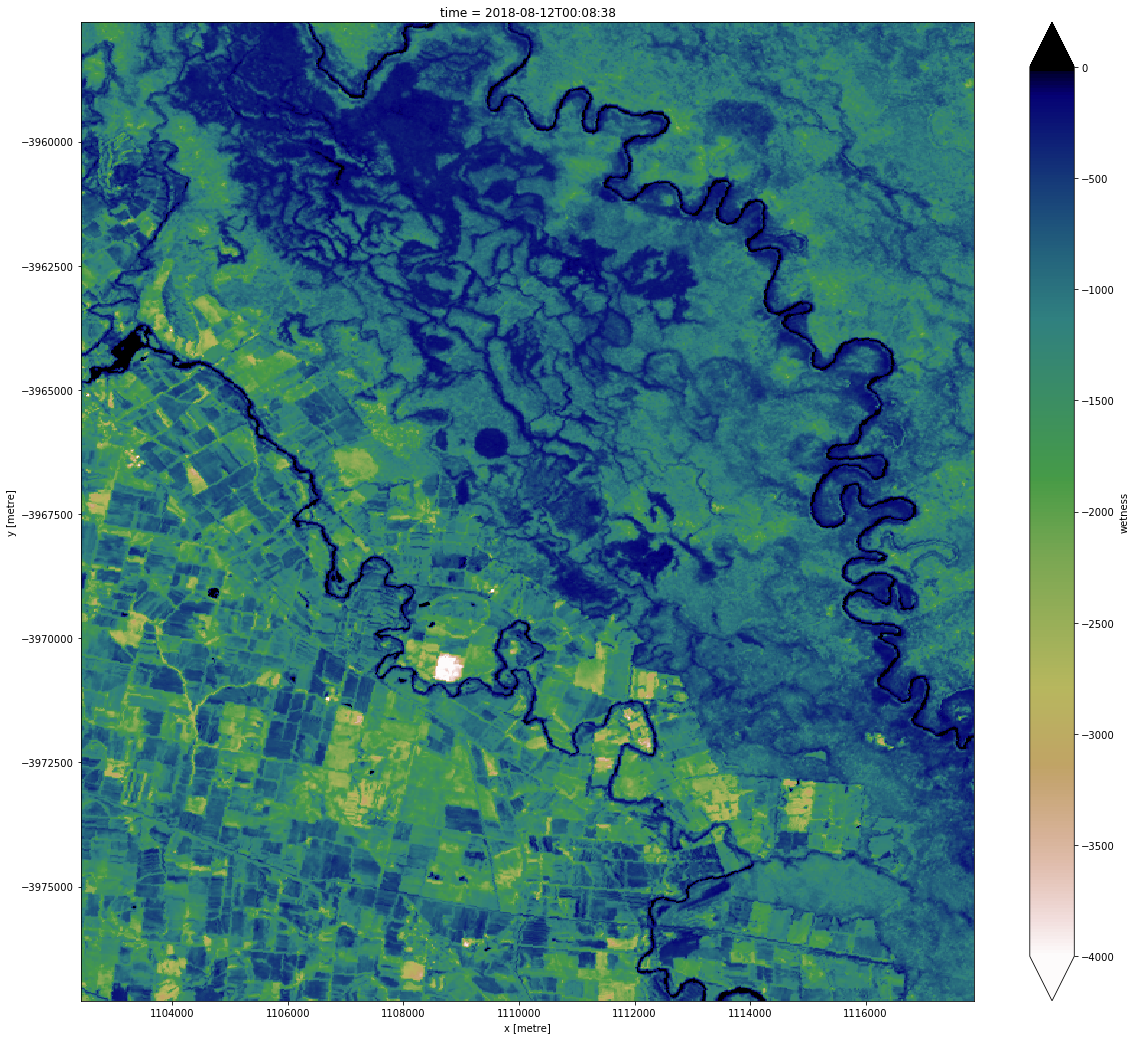

In [125]:
tcw.isel(time=1).plot(cmap='gist_earth_r',figsize=(20,18), vmin=-4000, vmax=0)#note -4000 is very low

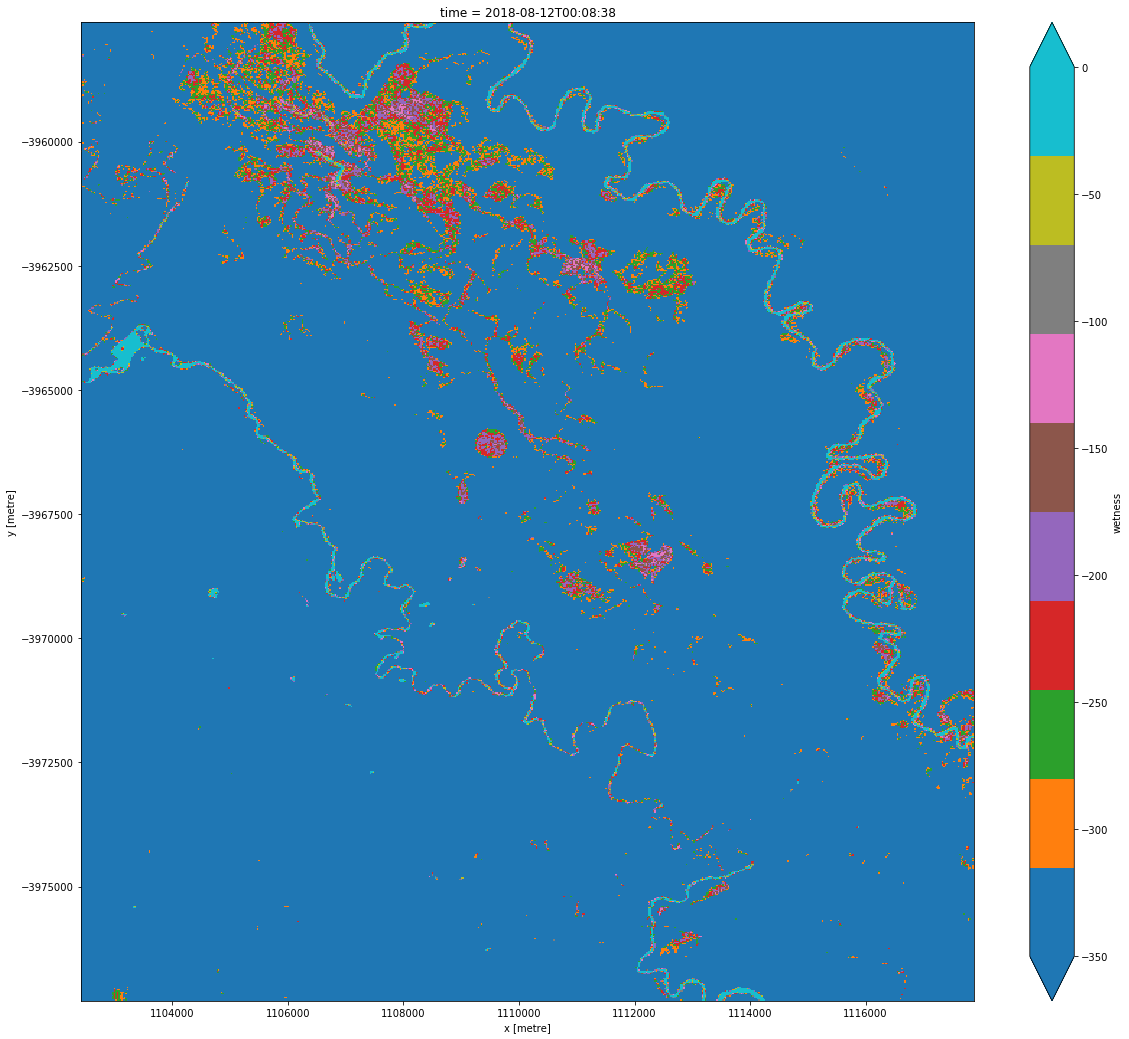

In [137]:
tcw.isel(time=1).plot(cmap='tab10',figsize=(20,18), vmin=-350, vmax=0)#note -4000 is very low

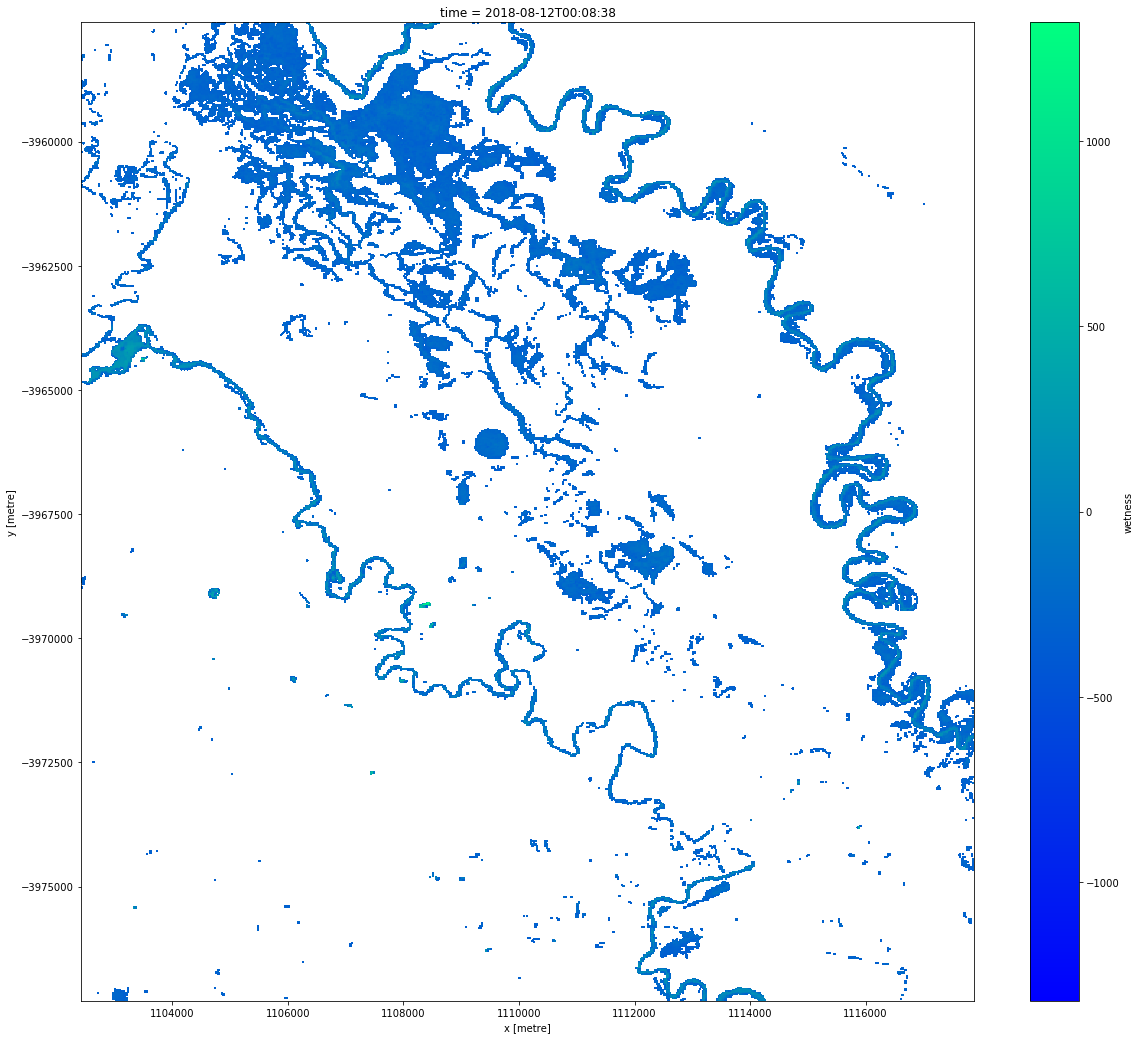

In [134]:
TCW_wet = tcw.isel(time=1).where(tcw.isel(time=1)>-350)
TCW_wet.plot(cmap='winter',figsize=(20,18))

In [128]:
by_tassle_not_wofs = TCW_wet.where(wofs_wet==1)

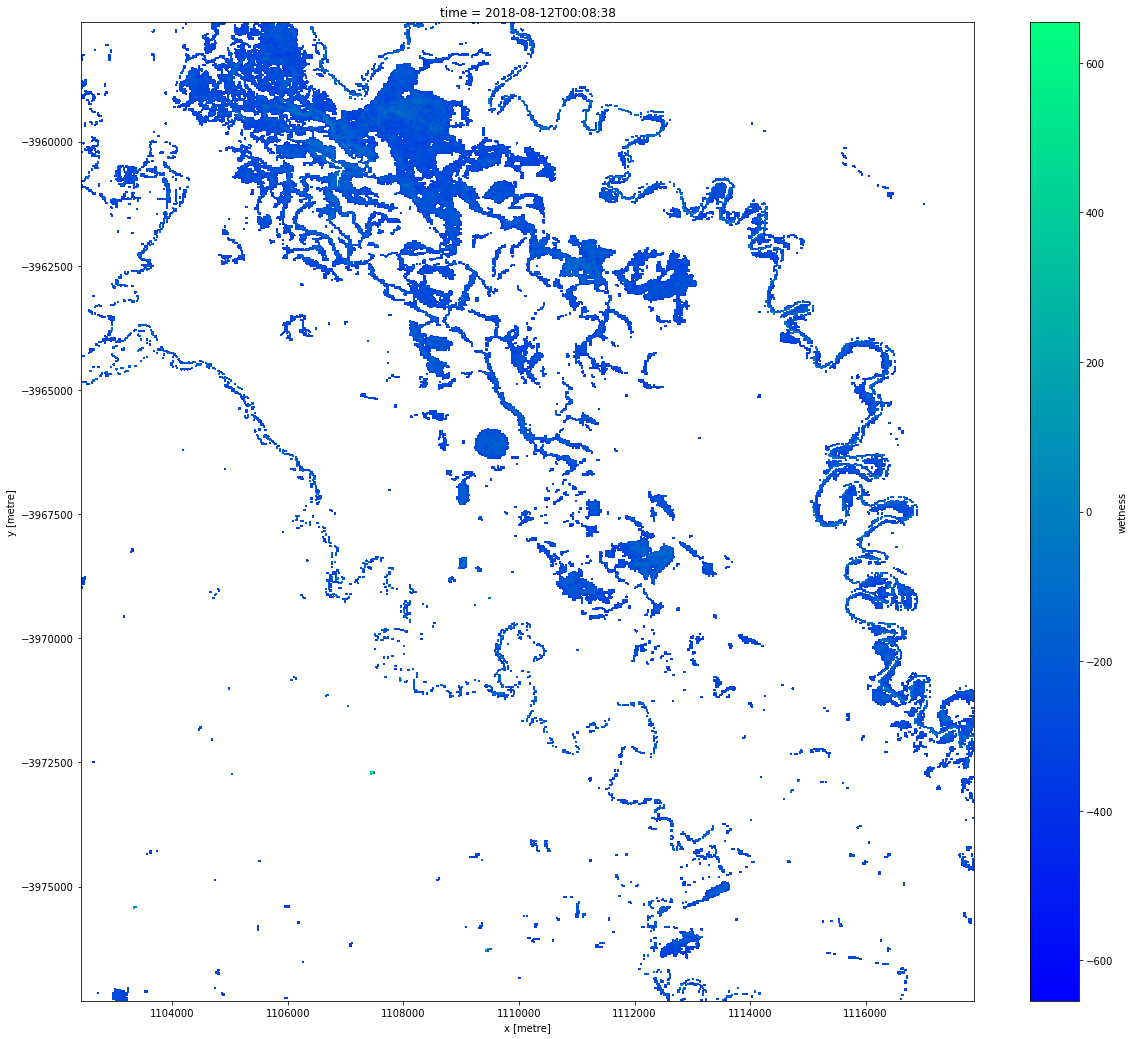

In [131]:
by_tassle_not_wofs.plot(cmap='winter',figsize=(20,18))

In [142]:
#plot wetness against brightness

flat_wetness = TCI['wetness'].values.ravel()
flat_brightness = TCI['brightness'].values.ravel()

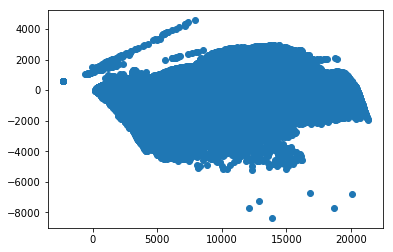

In [143]:
plt.scatter(flat_brightness,flat_wetness)
plt.show()